In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('reviews.csv')
df.head()

,beer_id,username,date,text,look,smell,taste,feel,overall,score
0,271781,bluejacket74,2017-03-17,"750 ml bottle, 2016 vintage, bottle #304 of...",4.00,4.00,4.00,4.25,4.00,4.03
1,125646,_dirty_,2017-12-21,,4.50,4.50,4.50,4.50,4.50,4.50
2,125646,CJDUBYA,2017-12-21,,4.75,4.75,4.75,4.75,4.75,4.75
3,125646,GratefulBeerGuy,2017-12-20,0% 16 oz can. Funny story: As I finally wal...,4.75,4.75,4.50,4.50,4.50,4.58
4,125646,LukeGude,2017-12-20,Classic TH NEIPA. Overflowing head and bouq...,4.25,4.50,4.25,4.25,4.25,4.31


In [3]:
print(df.shape) #원본 데이터 900만개를 사용

(9073128, 10)


In [4]:
#잠깐 전처리

cols = ['beer_id','username','score']
df = df[cols]
df.rename(columns = {'beer_id':'beerid','username':'userid','score':'rating'}, inplace = True)
df.head()

,beerid,userid,rating
0,271781,bluejacket74,4.03
1,125646,_dirty_,4.50
2,125646,CJDUBYA,4.75
3,125646,GratefulBeerGuy,4.58
4,125646,LukeGude,4.31


In [5]:
#딥러닝에 이용할 컬럼 변경: user, beer, rating

user_enc = LabelEncoder()
uid = df['userid'].values
df['user'] = user_enc.fit_transform(uid.tolist()) #array 인식이 안돼서 list로 빼냄.(userid의 경우만 오류 발생)
n_users = df['user'].nunique()

In [6]:
item_enc = LabelEncoder()
df['beer'] = item_enc.fit_transform(df['beerid'].values)
n_beers = df['beer'].nunique()

df['rating'] = df['rating'].values.astype(np.float32)
min_rating = min(df['rating'])
max_rating = max(df['rating'])

n_users, n_beers, min_rating, max_rating #n_users, n_beers: 유니크한 값 개수, rating의 최솟값과 최댓값.

(164935, 309542, 1.0, 5.0)

In [7]:
df2=df[['user','beer','rating']] 
df2.head() #완료된 데이터셋. 여기서 'user','beer','rating'만 사용

,user,beer,rating
0,102213,231507,4.03
1,94429,112229,4.50
2,15635,112229,4.75
3,34826,112229,4.58
4,55007,112229,4.31


In [8]:
#train, test 셋 분할: test size는 0.2, random_state는 임의로 지정
X = df[['user', 'beer']].values
y = df['rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7258502, 2), (1814626, 2), (7258502,), (1814626,))

In [9]:
#딥러닝 모델을 만들 때 필요한 또다른 변수는: 잠재요인의 개수를 정하는 것!
#잠재요인의 개수는 원하는 대로 설정하면 되지만, 주의할 것은 user와 beer 모두에 대해 같은 사이즈를 줘야 한다는 점.

#우리는 50개로 간다!(X에 대해서만 적용)
n_factors = 50

#X를 array로 만들기
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [10]:
beers = pd.read_csv('beers.csv')
beers.head()

,id,name,brewery_id,state,country,style,availability,abv,notes,retired
0,202522,Olde Cogitator,2199,CA,US,English Oatmeal Stout,Rotating,7.3,No notes at this time.,f
1,82352,Konrads Stout Russian Imperial Stout,18604,NaN,NO,Russian Imperial Stout,Rotating,10.4,No notes at this time.,f
2,214879,Scottish Right,44306,IN,US,Scottish Ale,Year-round,4.0,No notes at this time.,t
3,320009,MegaMeow Imperial Stout,4378,WA,US,American Imperial Stout,Winter,8.7,Every time this year,f
4,246438,Peaches-N-Cream,44617,PA,US,American Cream Ale,Rotating,5.1,No notes at this time.,f


In [11]:
## create a dictionary out of beerid, beer original title
beers_dict = beers.set_index('id')['name'].to_dict()

In [12]:
##시각화(각 epoch마다의 MSE, MAE 값 비교)

def plot_history(hist):
    
    plt.figure(figsize=(10,15))

    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [rating]')
    plt.plot(hist['epoch'], hist['mae'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],label = 'Test Error')
    plt.legend()

    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$rating^2$]')
    plt.plot(hist['epoch'], hist['mse'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],label = 'Test Error')
    plt.legend()
    plt.show()


# Recommdation System using Keras 
- 각 유저와 각 맥주를 나타내기 위해 'embedding'이라는 것을 활용한다.->(설명부분 캡처)
- 'embeddings'는 벡터이다(n_factor 사이즈의). 시작은 랜덤한 숫자로 가고, 각 유저/맥주의 필수적인 특징을 잡으면 fit model을 해보자.
- fit model 과정) 유저 벡터와 맥주 벡터를 스칼라곱(dot product)하여 예측 평점을 계산함.
- 이를 위해선 유니크한 유저 수와 맥주 수가 필요, -> 각각의 embedding matrix의 사이즈를 정의하기 위함.

In [13]:
#keras 라이브러리 로드
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding, Dense, Dropout
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.layers import Add, Activation, Lambda, Concatenate

Using TensorFlow backend.


# 옵티마이저: RMSprop이 더 성능 좋았으므로, 이걸로 돌림
- RecommenderV13: RMSprop, 레이어2, dropout1 ->결과 보면, dropout 자체를 안쓰려고 함.
- RecommenderV14: RMSprop, 레이어2, kernel에 L2(0.001)
- RecommenderV15: RMSprop, 레이어2, kernel에 L2(0.001) + activity에 L1(0.01)

- 케라스 규제참고: https://keras.io/regularizers/
- 케라스의 규제로는 dropout외, L1, L2가 있으며 각각은 라쏘와 릿지이다. 
- L1,L2는 커널 or bias or activity에 걸 수 있음.

In [16]:
from keras.layers import Concatenate, Dense, Dropout

#output에 dropout을 추가한 버전
##특히 dense layer를 2개 추가하였으며, 그 activation은 relu, sigmoid이다. 
#옵티마이저는 RMSprop

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal')(x) 
        x = Reshape((self.n_factors,))(x)
        return x


def RecommenderV13(n_users, n_movies, n_factors, min_rating, max_rating):
   
    #input: user, beer
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    beer = Input(shape=(1,))
    b = EmbeddingLayer(n_beers, n_factors)(beer)
    
    #output: x, 연산과정
    x = Concatenate()([u, b])
  
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    #완성되는 model
    model = Model(inputs=[user, beer], outputs=x)
    model.compile(loss=['mse'], metrics = ['mae','mse'] ,optimizer='RMSprop')

    return model

In [17]:
re13model = RecommenderV13(n_users, n_beers, n_factors, min_rating, max_rating)
re13model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        8246750     input_2[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 50)        15477100    input_3[0][0]                    
____________________________________________________________________________________________

In [18]:
## fit model
seed = 7
np.random.seed(seed)
history_mf = re13model.fit(x=X_train_array, y=y_train, batch_size=1000, epochs=10,
                    verbose=1, validation_data=(X_test_array, y_test)) 


Train on 7258502 samples, validate on 1814626 samples
Epoch 1/10
7258502/7258502 [==============================] - 1400s 193us/step - loss: 0.2440 - mae: 0.3554 - mse: 0.2440 - val_loss: 0.1949 - val_mae: 0.3113 - val_mse: 0.1949
Epoch 2/10
7258502/7258502 [==============================] - 1386s 191us/step - loss: 0.2158 - mae: 0.3305 - mse: 0.2158 - val_loss: 0.1915 - val_mae: 0.3080 - val_mse: 0.1915
Epoch 3/10
7258502/7258502 [==============================] - 1387s 191us/step - loss: 0.2120 - mae: 0.3270 - mse: 0.2120 - val_loss: 0.1889 - val_mae: 0.3053 - val_mse: 0.1889
Epoch 4/10
7258502/7258502 [==============================] - 1390s 191us/step - loss: 0.2098 - mae: 0.3249 - mse: 0.2098 - val_loss: 0.1879 - val_mae: 0.3045 - val_mse: 0.1879
Epoch 5/10
7258502/7258502 [==============================] - 1393s 192us/step - loss: 0.2083 - mae: 0.3236 - mse: 0.2083 - val_loss: 0.1860 - val_mae: 0.3024 - val_mse: 0.1860
Epoch 6/10
7258502/7258502 [==============================] 

In [19]:
## show loss & mae & mse at each epoch
hist13 = pd.DataFrame(history_mf.history)
hist13['epoch'] = history_mf.epoch
hist13

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
0,0.194875,0.311298,0.194875,0.244048,0.355414,0.244047,0
1,0.191522,0.308022,0.191522,0.215773,0.330451,0.215773,1
2,0.188914,0.305316,0.188914,0.212021,0.326991,0.212021,2
3,0.187904,0.304473,0.187904,0.209754,0.324916,0.209754,3
4,0.186050,0.302422,0.186050,0.208266,0.323567,0.208266,4
5,0.185977,0.302395,0.185977,0.207117,0.322494,0.207117,5
6,0.184769,0.301921,0.184769,0.206395,0.321764,0.206394,6
7,0.185401,0.301937,0.185401,0.205681,0.321142,0.205681,7
8,0.184642,0.301043,0.184642,0.205154,0.320670,0.205154,8
9,0.184466,0.302388,0.184466,0.204728,0.320251,0.204728,9


In [20]:
#모델 평가하기; model.evaluate()
loss_and_metrics = re13model.evaluate(X_test_array, y_test, batch_size=1000)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

1814626/1814626 [==============================] - 7s 4us/step
## evaluation loss and_metrics ##
[0.18446611288741277, 0.30238789319992065, 0.18446588516235352]


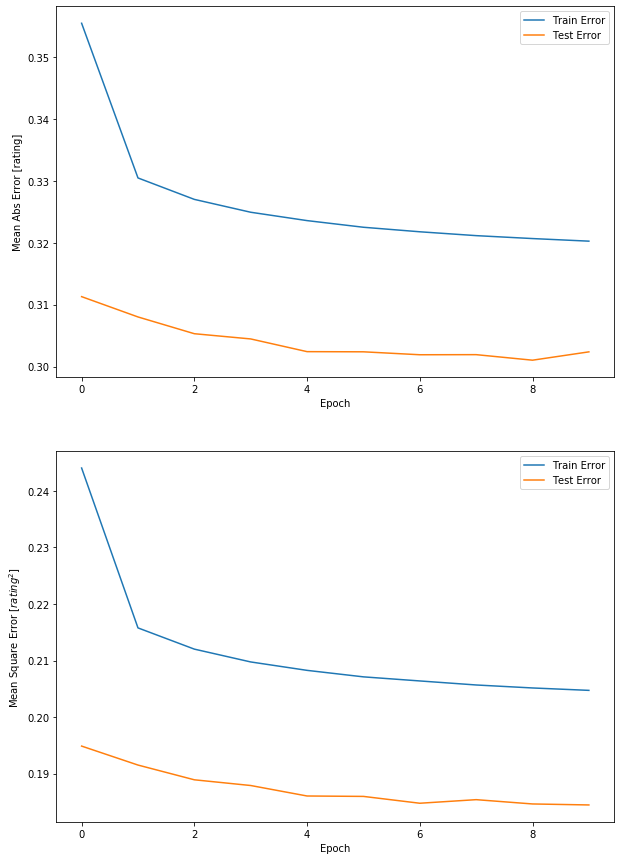

In [21]:
plot_history(hist13)

In [22]:
def get_unbeer_keras(df, userid):
    beers = df[df['user']==userid]['beer'].unique().tolist() #해당 유저가 평가한 beer
    total_beers = df['beer'].unique().tolist() #모든 beer
    unbeers = [beer for beer in total_beers if beer not in beers] #해당 유저가 평가안한 beer
    return unbeers

def recomm_beer_by_keras(userid, model, top_n):
    unbeers = get_unbeer_keras(df,userid)
    predict =[v[0][0] for v in  [model.predict([[userid],[beer]]) for beer in unbeers]]
    ndf= pd.DataFrame({'beer':unbeers,'rating':predict})
    final = ndf.sort_values(by='rating', ascending=False)[:top_n]
    return final


In [23]:
%%time

unbeers = get_unbeer_keras(df2, 190)
recomm_beer_by_keras(190, re13model, 10)

Wall time: 6min 15s


,beer,rating
186538,68022,4.824777
191828,52574,4.775228
210211,122288,4.747730
108760,34828,4.733747
12954,76214,4.690979
169444,98340,4.686193
182975,13645,4.680044
290539,51395,4.679646
15542,76794,4.664147
85480,86880,4.655080


In [24]:
## get weights of the beers embedding matrix
beer_embedding_weights = re13model.layers[3].get_weights()[0] #3은 beer-embedding : layer 확인!
beer_embedding_weights.shape

(309542, 50)

In [25]:
## import PCA
pca = PCA(n_components = 3) ## use 3 components
beer_embedding_weights_t = np.transpose(beer_embedding_weights) ## pass the transpose of the embedding matrix
beer_pca = pca.fit(beer_embedding_weights_t) ## fit

## display the resulting matrix dimensions
beer_pca.components_.shape

(3, 309542)

In [26]:
## display the variance explained by the 3 components
beer_pca.explained_variance_ratio_
 #variance 가 아주 낮으면 좋은 해석을 기대하기 어렵다.
    #첫번째 PC 분산은 약 얼마? 78%로, dropout 규제를 넣었는데도 성능이 좋다!

array([0.93086463, 0.05413963, 0.00361837], dtype=float32)

In [27]:
from operator import itemgetter

## extract first PCA
pca0 = beer_pca.components_[0]

## get the value (pca0, beer title)
beer_comp0 = [(f, beers_dict[i]) for f,i in zip(pca0, list(beers_dict.keys()))]

In [28]:
## beers corresponding to the highest values of pca0
sorted(beer_comp0, key = itemgetter(0), reverse = True)[:10]

[(0.010736336, 'Grid Iron Irish Red'),
 (0.010144114, 'Nocturnality'),
 (0.009857028, 'Dirty Bastard - Bourbon-Soaked Apricots And Ginger'),
 (0.009801656, 'Sir Phobos'),
 (0.009741707, 'Pomegranate kolsch'),
 (0.0097121075, 'Ahhh You Again'),
 (0.009654376, 'Rolo Tony Brown Town'),
 (0.009333192, "Weekend At Brett's Barrel Aged"),
 (0.009243805, 'Janis Hoplin'),
 (0.008856212, 'Mele Kalikimaka Coconut Porter')]

In [29]:
## beers corresponding to the lowest values of pca0
sorted(beer_comp0, key = itemgetter(0))[:10]

[(-0.04050416, 'Snowman Make Like A Tree And Leaf Maple Porter'),
 (-0.035838056, 'Jolly Golden Ale'),
 (-0.034587532, "Monk's Phunk"),
 (-0.03345729, 'G-Spot Jalapeno Ale'),
 (-0.03076992, 'Handlebar Hefe'),
 (-0.030741971, 'One-Eyed Jack Imperial Pilsner'),
 (-0.03060478, "'Sconnie Badger Brown Ale"),
 (-0.029868336, 'Winter Sesh'),
 (-0.02947721, 'La Grand Duc (Rousse Au Seigle)'),
 (-0.029219901, 'Saison Garni')]

# dropout은 안 쓰기로 함! L2규제를 각 레이어에 추가하여 성능을 보자.

In [30]:
#dense layer에 L2 규제를 추가한 버전, 연산의 layer도 2개 더 추가하였다.
##bias가 있음// + activation을 추가(sigmoid), 연산할 때 평점의 min, max도 함께 고려한다.
##옵티마이저가 RMSprop

def RecommenderV14(n_users, n_movies, n_factors, min_rating, max_rating):
   
    #input: user, beer
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    beer = Input(shape=(1,))
    b = EmbeddingLayer(n_beers, n_factors)(beer)
    
    #output: x, 연산과정
    x = Concatenate()([u, b])
    
    x = Dense(10, kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(x) #L2 규제 추가
    x = Activation('relu')(x)
    
    x = Dense(1, kernel_initializer='he_normal',kernel_regularizer=l2(0.001))(x) #L2 규제 추가
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    #완성되는 model
    model = Model(inputs=[user, beer], outputs=x)
    model.compile(loss=['mse'], metrics = ['mae','mse'] ,optimizer='RMSprop')

    return model


In [31]:
re14model = RecommenderV14(n_users, n_beers, n_factors, min_rating, max_rating)
re14model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 1, 50)        8246750     input_4[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 50)        15477100    input_5[0][0]                    
____________________________________________________________________________________________

In [32]:
## fit model
seed = 7
np.random.seed(seed)
history_mf = re14model.fit(x=X_train_array, y=y_train, batch_size=1000, epochs=10,
                    verbose=1, validation_data=(X_test_array, y_test)) 

Train on 7258502 samples, validate on 1814626 samples
Epoch 1/10
7258502/7258502 [==============================] - 1417s 195us/step - loss: 0.2144 - mae: 0.3235 - mse: 0.2082 - val_loss: 0.1975 - val_mae: 0.3093 - val_mse: 0.1928
Epoch 2/10
7258502/7258502 [==============================] - 1385s 191us/step - loss: 0.1916 - mae: 0.3034 - mse: 0.1869 - val_loss: 0.1929 - val_mae: 0.3055 - val_mse: 0.1886
Epoch 3/10
7258502/7258502 [==============================] - 1376s 190us/step - loss: 0.1864 - mae: 0.2984 - mse: 0.1821 - val_loss: 0.1899 - val_mae: 0.3030 - val_mse: 0.1858
Epoch 4/10
7258502/7258502 [==============================] - 1374s 189us/step - loss: 0.1833 - mae: 0.2956 - mse: 0.1792 - val_loss: 0.1889 - val_mae: 0.3015 - val_mse: 0.1850
Epoch 5/10
7258502/7258502 [==============================] - 1369s 189us/step - loss: 0.1812 - mae: 0.2936 - mse: 0.1773 - val_loss: 0.1881 - val_mae: 0.3010 - val_mse: 0.1843
Epoch 6/10
7258502/7258502 [==============================] -

In [33]:
## show loss & mae & mse at each epoch
hist14 = pd.DataFrame(history_mf.history)
hist14['epoch'] = history_mf.epoch
hist14

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
0,0.197546,0.309324,0.192761,0.214435,0.323473,0.208152,0
1,0.192889,0.305476,0.188572,0.191605,0.303366,0.186933,1
2,0.189895,0.303037,0.185769,0.186371,0.298437,0.182055,2
3,0.188892,0.301481,0.184960,0.183324,0.295580,0.179220,3
4,0.188103,0.301014,0.184301,0.181247,0.293632,0.177321,4
5,0.187574,0.300454,0.183946,0.179687,0.292191,0.175910,5
6,0.187482,0.301398,0.183694,0.178343,0.290856,0.174608,6
7,0.186867,0.299455,0.183124,0.177110,0.289572,0.173322,7
8,0.187038,0.299219,0.183342,0.176155,0.288572,0.172353,8
9,0.187368,0.301914,0.183635,0.175340,0.287743,0.171560,9


In [34]:
#모델 평가하기; model.evaluate()
loss_and_metrics = re14model.evaluate(X_test_array, y_test, batch_size=1000)
print('## evaluation loss and_metrics ##')
print(loss_and_metrics)

1814626/1814626 [==============================] - 8s 4us/step
## evaluation loss and_metrics ##
[0.18736835497024054, 0.301913857460022, 0.18363521993160248]


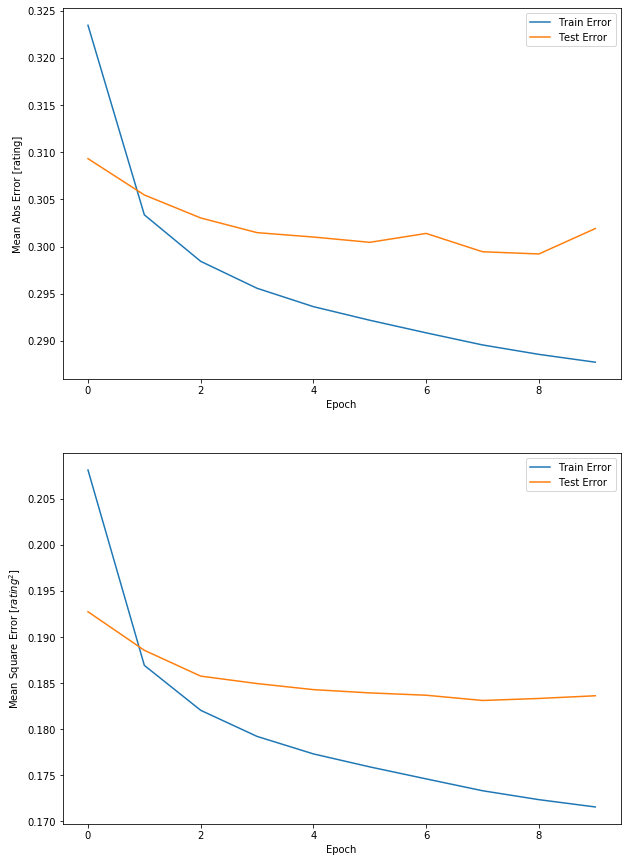

In [35]:
plot_history(hist14)

In [36]:
def get_unbeer_keras(df, userid):
    beers = df[df['user']==userid]['beer'].unique().tolist() #해당 유저가 평가한 beer
    total_beers = df['beer'].unique().tolist() #모든 beer
    unbeers = [beer for beer in total_beers if beer not in beers] #해당 유저가 평가안한 beer
    return unbeers

def recomm_beer_by_keras(userid, model, top_n):
    unbeers = get_unbeer_keras(df,userid)
    predict =[v[0][0] for v in  [model.predict([[userid],[beer]]) for beer in unbeers]]
    ndf= pd.DataFrame({'beer':unbeers,'rating':predict})
    final = ndf.sort_values(by='rating', ascending=False)[:top_n]
    return final

In [37]:
%%time

unbeers = get_unbeer_keras(df2, 190)
recomm_beer_by_keras(190, re14model, 10)

Wall time: 4min 58s


,beer,rating
186538,68022,4.825977
191828,52574,4.746490
210211,122288,4.727958
108760,34828,4.714993
85480,86880,4.689719
12954,76214,4.689309
169444,98340,4.687913
109217,80528,4.675450
290539,51395,4.664763
73822,185846,4.660795


In [38]:
## get weights of the beers embedding matrix
beer_embedding_weights = re14model.layers[3].get_weights()[0] #3은 beer-embedding : layer 확인!
beer_embedding_weights.shape

(309542, 50)

In [39]:
## import PCA
pca = PCA(n_components = 3) ## use 3 components
beer_embedding_weights_t = np.transpose(beer_embedding_weights) ## pass the transpose of the embedding matrix
beer_pca = pca.fit(beer_embedding_weights_t) ## fit

## display the resulting matrix dimensions
beer_pca.components_.shape

(3, 309542)

In [40]:
## display the variance explained by the 3 components
beer_pca.explained_variance_ratio_
 #variance 가 아주 낮으면 좋은 해석을 기대하기 어렵다.
    #첫번째 PC 분산은 약 얼마? 78%로, dropout 규제를 넣었는데도 성능이 좋다!

array([9.9927950e-01, 1.8998542e-05, 1.6598371e-05], dtype=float32)

In [41]:
from operator import itemgetter

## extract first PCA
pca0 = beer_pca.components_[0]

## get the value (pca0, beer title)
beer_comp0 = [(f, beers_dict[i]) for f,i in zip(pca0, list(beers_dict.keys()))]

In [42]:
## beers corresponding to the highest values of pca0
sorted(beer_comp0, key = itemgetter(0), reverse = True)[:10]

[(0.03897305, 'Snowman Make Like A Tree And Leaf Maple Porter'),
 (0.032054745, 'Jolly Golden Ale'),
 (0.03073786, "Monk's Phunk"),
 (0.029865708, 'G-Spot Jalapeno Ale'),
 (0.028268116, 'Saison Garni'),
 (0.028236136, 'Handlebar Hefe'),
 (0.028151834, 'One-Eyed Jack Imperial Pilsner'),
 (0.027413, 'Full Rosenberry'),
 (0.026798487, 'Winter Sesh'),
 (0.026572049, 'Seas The Day IPL')]

In [43]:
## beers corresponding to the lowest values of pca0
sorted(beer_comp0, key = itemgetter(0))[:10]

[(-0.0088316575, 'Sunday Driving'),
 (-0.0087829735, 'Cream Ale'),
 (-0.008557313, 'Grid Iron Irish Red'),
 (-0.008259866, 'Nocturnality'),
 (-0.008155828, 'Sir Phobos'),
 (-0.007877434, 'Carrabassett Pale Ale'),
 (-0.007852224, 'Bean Me Up Espresso Milk Stout'),
 (-0.007841992, 'Dirty Bastard - Bourbon-Soaked Apricots And Ginger'),
 (-0.007692527, 'Ahhh You Again'),
 (-0.007624732, "Weekend At Brett's Barrel Aged")]

# activation 규제 추가 --> 성능 안좋음 , 사용x

In [51]:
from keras.regularizers import l1

In [61]:
#dense layer에 L2 규제를 추가한 버전, activation에도 L1 규제를 추가해봄.
##bias가 있음// + activation을 추가(sigmoid), 연산할 때 평점의 min, max도 함께 고려한다.
##옵티마이저가 RMSprop

def RecommenderV15(n_users, n_movies, n_factors, min_rating, max_rating):
   
    #input: user, beer
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    beer = Input(shape=(1,))
    b = EmbeddingLayer(n_beers, n_factors)(beer)
    
    #output: x, 연산과정
    x = Concatenate()([u, b])
    
    x = Dense(10, kernel_initializer='he_normal',kernel_regularizer=l2(1e-6),activity_regularizer=l1(0.001))(x) #L2, L1 규제 추가 #규제 rate은 낮을수록 좋은 듯.
    x = Activation('relu')(x)
    
    x = Dense(1, kernel_initializer='he_normal',kernel_regularizer=l2(1e-6),activity_regularizer=l1(0.001))(x) #L2, L1 규제 추가
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)

    #완성되는 model
    model = Model(inputs=[user, beer], outputs=x)
    model.compile(loss=['mse'], metrics = ['mae','mse'] ,optimizer='RMSprop')

    return model


In [62]:
re15model = RecommenderV15(n_users, n_beers, n_factors, min_rating, max_rating)
re15model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_15 (Embedding)        (None, 1, 50)        8246750     input_16[0][0]                   
__________________________________________________________________________________________________
embedding_16 (Embedding)        (None, 1, 50)        15477100    input_17[0][0]                   
____________________________________________________________________________________________

In [63]:
## fit model
seed = 7
np.random.seed(seed)
history_mf = re15model.fit(x=X_train_array, y=y_train, batch_size=1000, epochs=10,
                    verbose=1, validation_data=(X_test_array, y_test)) 

Train on 7258502 samples, validate on 1814626 samples
Epoch 1/10
7258502/7258502 [==============================] - 1394s 192us/step - loss: 0.9749 - mae: 0.6418 - mse: 0.5488 - val_loss: 0.9678 - val_mae: 0.5220 - val_mse: 0.3800
Epoch 2/10
7258502/7258502 [==============================] - 1406s 194us/step - loss: 0.9245 - mae: 0.6006 - mse: 0.4738 - val_loss: 0.9619 - val_mae: 0.4911 - val_mse: 0.3440
Epoch 3/10
7258502/7258502 [==============================] - 1461s 201us/step - loss: 0.9137 - mae: 0.5952 - mse: 0.4640 - val_loss: 0.9492 - val_mae: 0.4830 - val_mse: 0.3347
Epoch 4/10
7258502/7258502 [==============================] - 1443s 199us/step - loss: 0.9085 - mae: 0.5927 - mse: 0.4592 - val_loss: 0.9514 - val_mae: 0.4732 - val_mse: 0.3243
Epoch 5/10
7258502/7258502 [==============================] - 1455s 200us/step - loss: 0.9052 - mae: 0.5911 - mse: 0.4561 - val_loss: 0.9390 - val_mae: 0.4861 - val_mse: 0.3362
Epoch 6/10
7258502/7258502 [==============================] -

In [64]:
## show loss & mae & mse at each epoch
hist15 = pd.DataFrame(history_mf.history)
hist15['epoch'] = history_mf.epoch
hist15

,val_loss,val_mae,val_mse,loss,mae,mse,epoch
0,0.967767,0.521959,0.380043,0.974936,0.641778,0.548825,0
1,0.961899,0.491051,0.343961,0.924480,0.600648,0.473792,1
2,0.949190,0.483001,0.334680,0.913735,0.595183,0.463995,2
3,0.951403,0.473190,0.324303,0.908526,0.592683,0.459170,3
4,0.938997,0.486102,0.336214,0.905166,0.591086,0.456080,4
5,0.922331,0.513352,0.365294,0.903206,0.589961,0.453970,5
6,0.924670,0.511560,0.363027,0.902044,0.589146,0.452370,6
7,0.940933,0.473527,0.322199,0.901374,0.588481,0.451074,7
8,0.948789,0.463951,0.313365,0.900850,0.587853,0.449872,8
9,0.940397,0.466724,0.315662,0.900589,0.587400,0.448990,9
